# Visualiser une image

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

def afficher_image_3D(path,deepth=0):
    img = nib.load(path)
    data = img.get_fdata()
    print(f"Dimensions: {data.shape}")

    # Afficher une coupe axiale au milieu
    plt.imshow(data[:, :, deepth], cmap='gray')
    plt.title("Coupe axiale (slice at depth {})".format(deepth))
    plt.axis('off')
    plt.show()
    return data

Dimensions: (512, 512, 91)


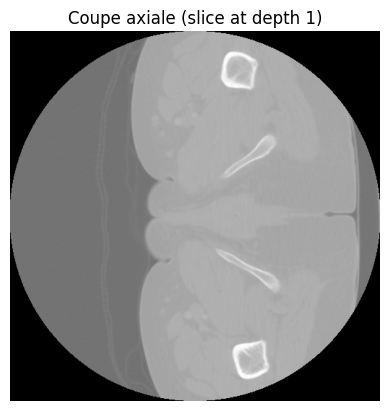

In [4]:
data = afficher_image_3D("./DatasetChallenge/images/330707.nii.gz", 1)

# Supperposer une image et son label 

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def afficher_image_et_masque(number, slice_index=None):
    path = "./DatasetChallenge/"
    image_path = path + "images/" + str(number) + ".nii.gz"
    masque_path = path + "labels/" + str(number) + ".nii.gz"
    image = nib.load(image_path).get_fdata()
    masque = nib.load(masque_path).get_fdata()

    assert image.shape == masque.shape, "Image et masque doivent avoir les mêmes dimensions"

    if slice_index is None:
        slice_index = image.shape[2] // 2  # Coupe axiale au milieu

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, slice_index], cmap='gray')
    plt.title("Image (Coupe axiale)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masque[:, :, slice_index], cmap='gray')
    plt.title("Masque de tumeur")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image[:, :, slice_index], cmap='gray')
    plt.imshow(masque[:, :, slice_index], alpha=0.4, cmap='Reds')
    plt.title("Superposition")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


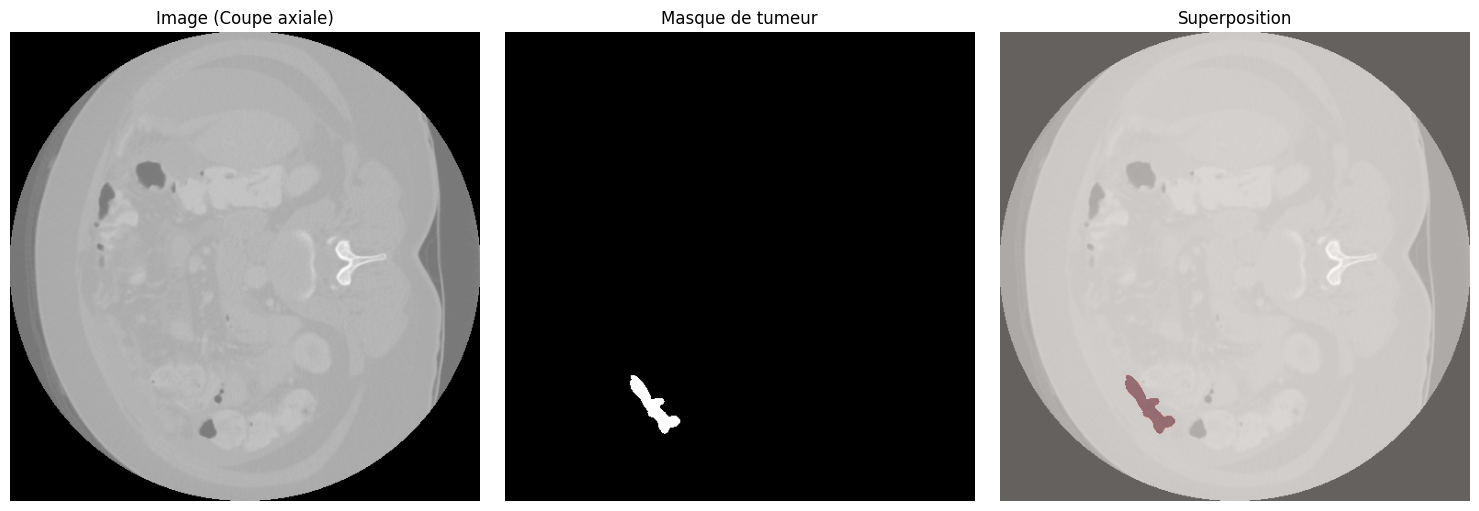

In [6]:
afficher_image_et_masque(330707, 52)

# Création Pytorch Dataset

In [7]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T

class OvarianDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, slice_axis=2):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.filenames = sorted(os.listdir(images_dir))
        self.transform = transform
        self.slice_axis = slice_axis  # 0, 1 ou 2

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        label_path = os.path.join(self.labels_dir, self.filenames[idx])

        image = nib.load(img_path).get_fdata()
        label = nib.load(label_path).get_fdata()

        # On prend une coupe au milieu pour simplifier (2D)
        middle = image.shape[self.slice_axis] // 2
        if self.slice_axis == 0:
            image = image[middle, :, :]
            label = label[middle, :, :]
        elif self.slice_axis == 1:
            image = image[:, middle, :]
            label = label[:, middle, :]
        else:
            image = image[:, :, middle]
            label = label[:, :, middle]

        # Normalisation simple
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        return image, label


In [8]:
from torch.utils.data import DataLoader
path_images = "./DatasetChallenge/images"
path_labels = "./DatasetChallenge/labels"

dataset = OvarianDataset(path_images, path_labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Tester un batch
for x, y in dataloader:
    print("Image:", x.shape)  # [B, 1, H, W]
    print("Label:", y.shape)  # [B, 1, H, W]
    break


Image: torch.Size([4, 1, 512, 512])
Label: torch.Size([4, 1, 512, 512])


# Modèle : Mini U-Net

In [9]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """Deux convolutions + ReLU + BatchNorm"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(1, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)  # binaire

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        b = self.bottleneck(self.pool2(d2))

        u1 = self.up1(b)
        u1 = self.upconv1(torch.cat([u1, d2], dim=1))
        u2 = self.up2(u1)
        u2 = self.upconv2(torch.cat([u2, d1], dim=1))

        out = self.final_conv(u2)
        return torch.sigmoid(out)  # probas entre 0 et 1


## fonction de perte : Dice loss

In [10]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


## fonction d'entrainement 

In [11]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        images, masks = batch  # car DataLoader retourne (image, label)
        images = images.to(device)
        masks = masks.to(device)


        preds = model(images)
        loss = dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


## Fonction de validation 


In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    dice_score = 0

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds = (preds > 0.5).float()  # Binarisation

            intersection = (preds * masks).sum(dim=(1,2,3))
            union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
            dice = (2. * intersection + 1e-6) / (union + 1e-6)

            dice_score += dice.mean().item()

    return dice_score / len(dataloader)


## boucle d'entrainement 

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


total_size = len(dataset)
# 80% train, 20% validation
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, pin_memory=True)
n_epochs = 3

for epoch in range(n_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    val_dice = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Dice: {val_dice:.4f}")



100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


Epoch 1/3 - Train Loss: 0.9867 - Val Dice: 0.0187


100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


Epoch 2/3 - Train Loss: 0.9847 - Val Dice: 0.0203


100%|██████████| 40/40 [03:38<00:00,  5.47s/it]


Epoch 3/3 - Train Loss: 0.9835 - Val Dice: 0.0234


In [14]:
import matplotlib.pyplot as plt

def show_prediction(model, dataset, device, index=0):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[index]
        image = image.unsqueeze(0).to(device)  # batch dimension
        pred = model(image)
        pred = pred.squeeze().cpu().numpy()  # 2D
        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(image, cmap="gray")

        plt.subplot(1,3,2)
        plt.title("Masque réel")
        plt.imshow(mask, cmap="gray")

        plt.subplot(1,3,3)
        plt.title("Prédiction")
        plt.imshow(pred > 0.5, cmap="gray")  # seuil à 0.5
        plt.show()


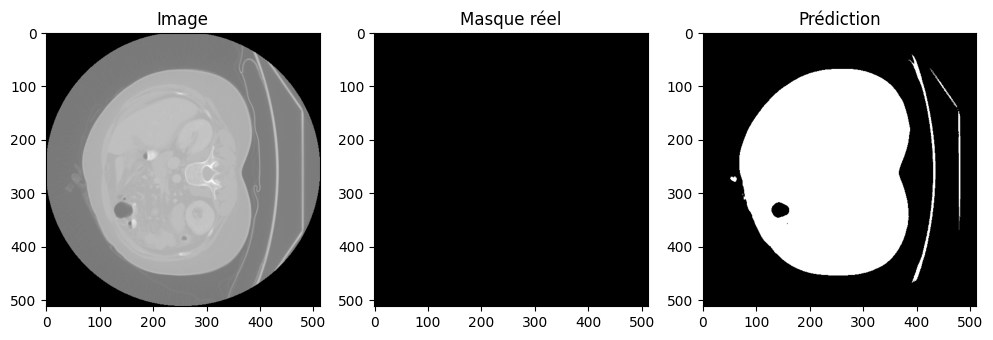

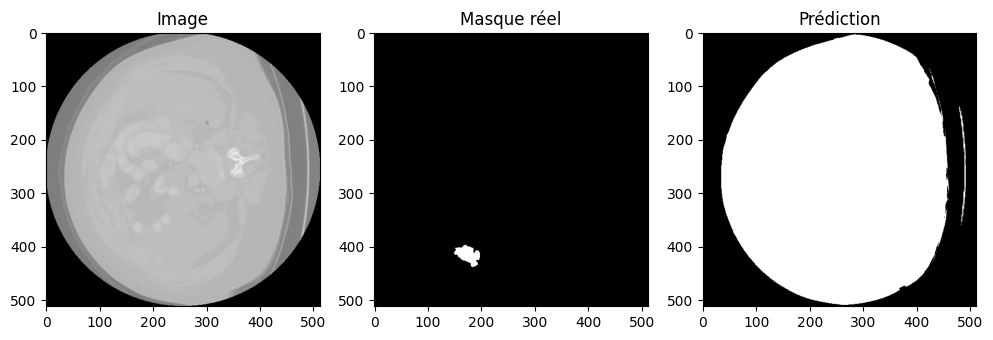

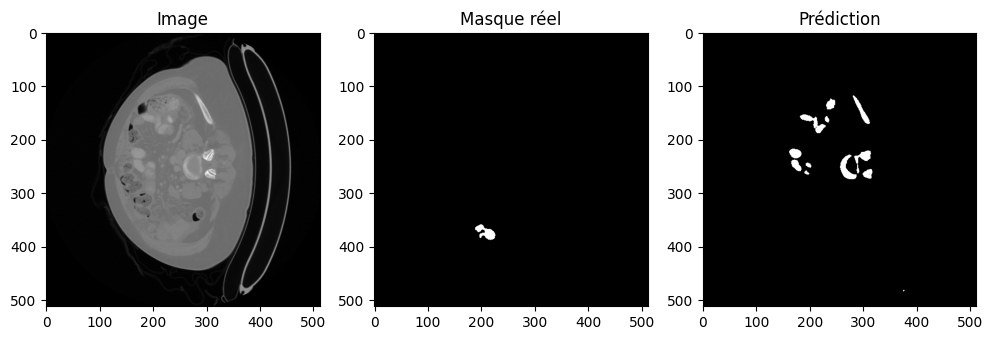

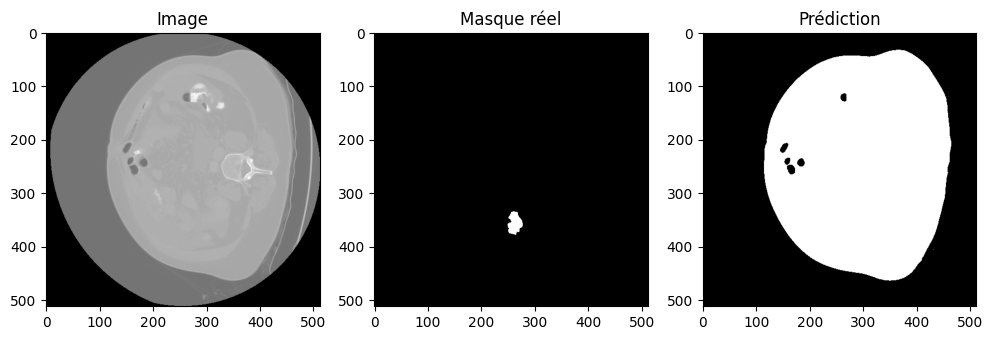

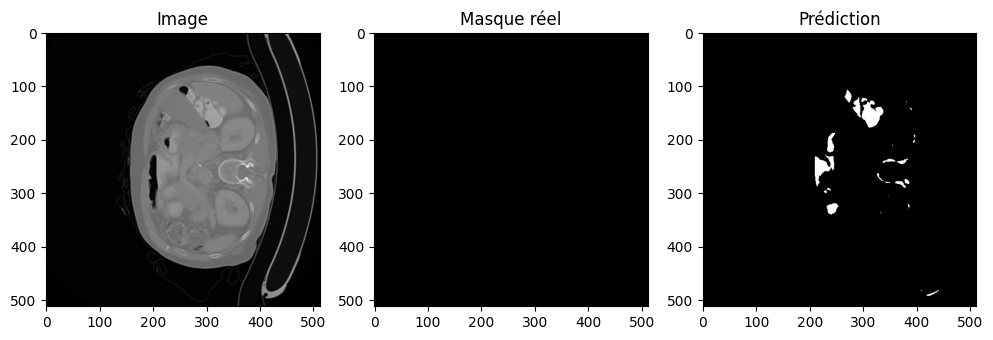

In [15]:
# Visualiser plusieurs prédictions pour évaluer la qualité
for i in range(5):
    show_prediction(model, val_dataset, device, index=i)


## Fonction d'évaluation 

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device, threshold=0.5, n_examples=3):
    model.eval()
    dices = []

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch[0].to(device), batch[1].to(device)
            masks = (masks > 0).float()  # Binarisation des classes 1 et 2

            preds = model(images)
            preds = torch.sigmoid(preds)
            preds = (preds > threshold).float()

            intersection = (preds * masks).sum(dim=(1, 2, 3))
            dice = (2. * intersection) / (preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) + 1e-8)
            dices.extend(dice.cpu().numpy())

    avg_dice = np.mean(dices)
    print(f"Score Dice moyen sur le dataset d'évaluation : {avg_dice:.4f}")
    
    model.train()
    display_examples(model, dataloader, device, threshold, n_examples)

def display_examples(model, dataloader, device, threshold=0.5, n_examples=3):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch[0].to(device), batch[1].to(device)
            masks = (masks > 0).float()
            preds = model(images)
            preds = torch.sigmoid(preds)
            preds = (preds > threshold).float()

            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            preds = preds.cpu().numpy()

            batch_size = images.shape[0]
            for i in range(batch_size):
                if images_shown >= n_examples:
                    return

                image = images[i, 0, :, :]
                mask = masks[i, 0, :, :]
                pred = preds[i, 0, :, :]

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(image, cmap='gray')
                axes[0].set_title('Image')
                axes[1].imshow(mask, cmap='gray')
                axes[1].set_title('Masque Vérité')
                axes[2].imshow(pred, cmap='gray')
                axes[2].set_title('Prédiction')
                plt.show()

                images_shown += 1


Score Dice moyen sur le dataset d'évaluation : 0.0062


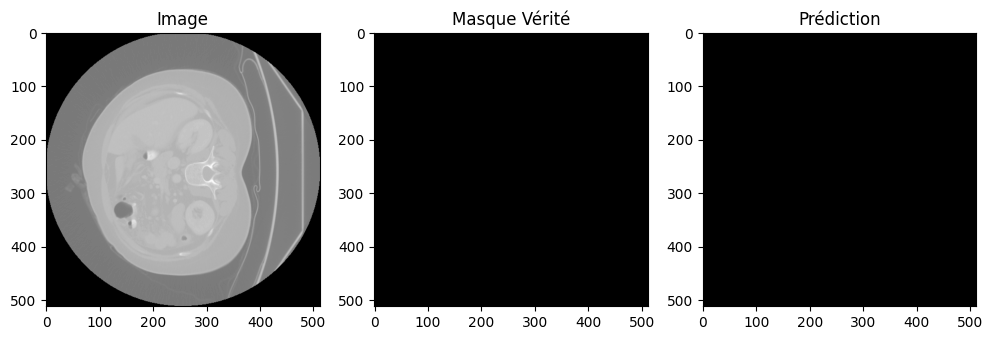

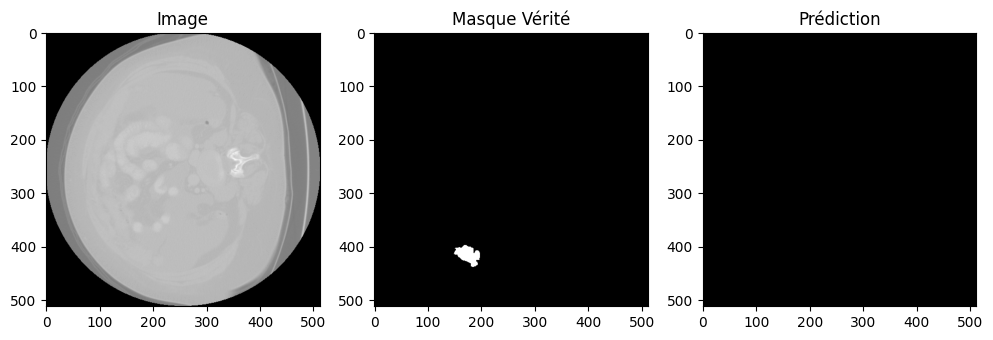

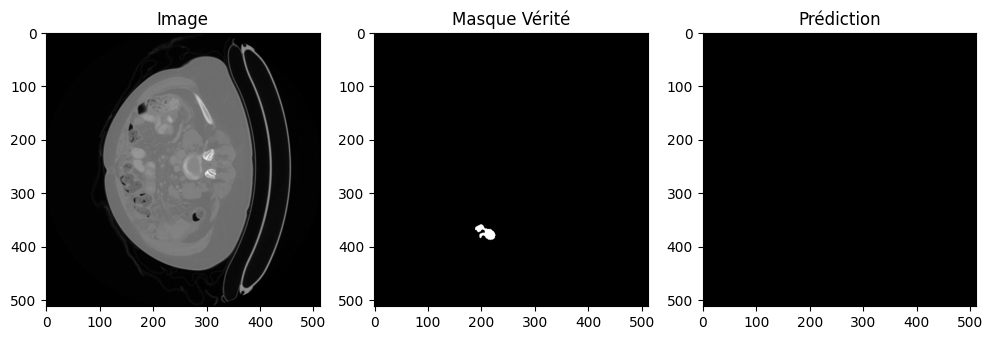

In [24]:
evaluate_model(model, val_loader, device)


## Save Model

In [25]:
import torch

# Enregistrement des poids du modèle
name = "1_0-0062"+".pth"
torch.save(model.state_dict(), name)
print("Modèle sauvegardé sous le nom ", name)


Modèle sauvegardé sous le nom  1_0-0062.pth
